Pixels: 10500
Min: -9556.747, Median: 1.000, Mean: 334.256, Max: 236220.359, Std: 3257.667


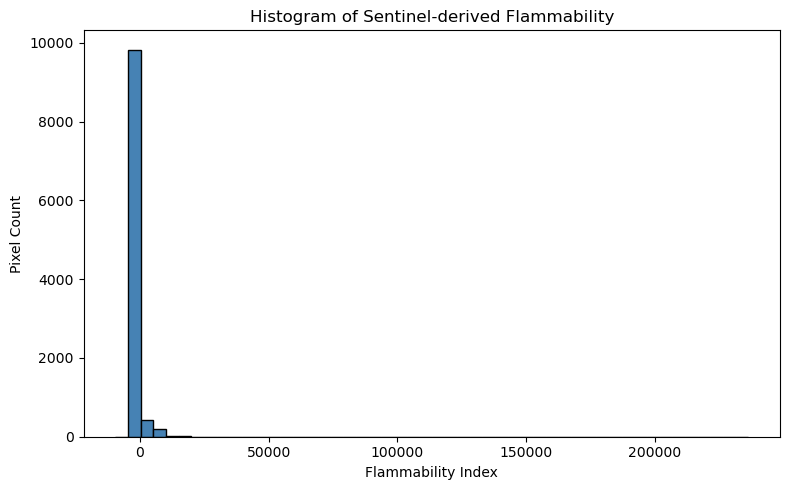

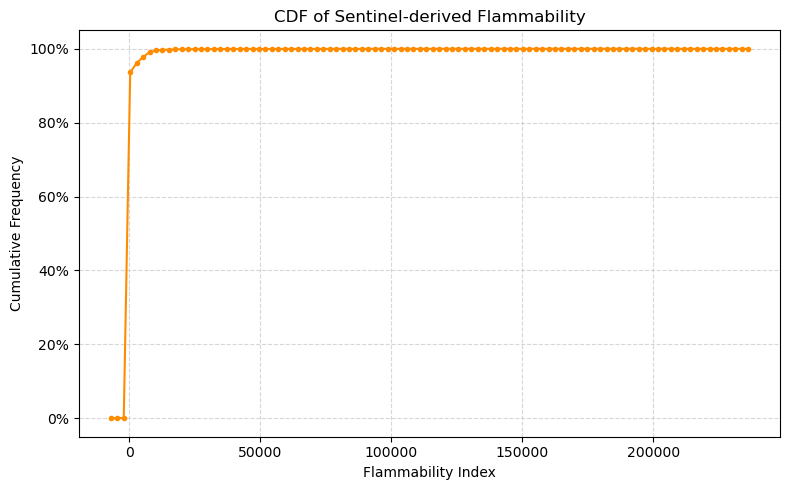

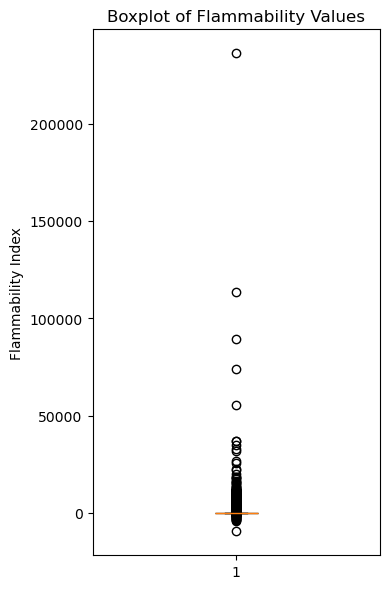

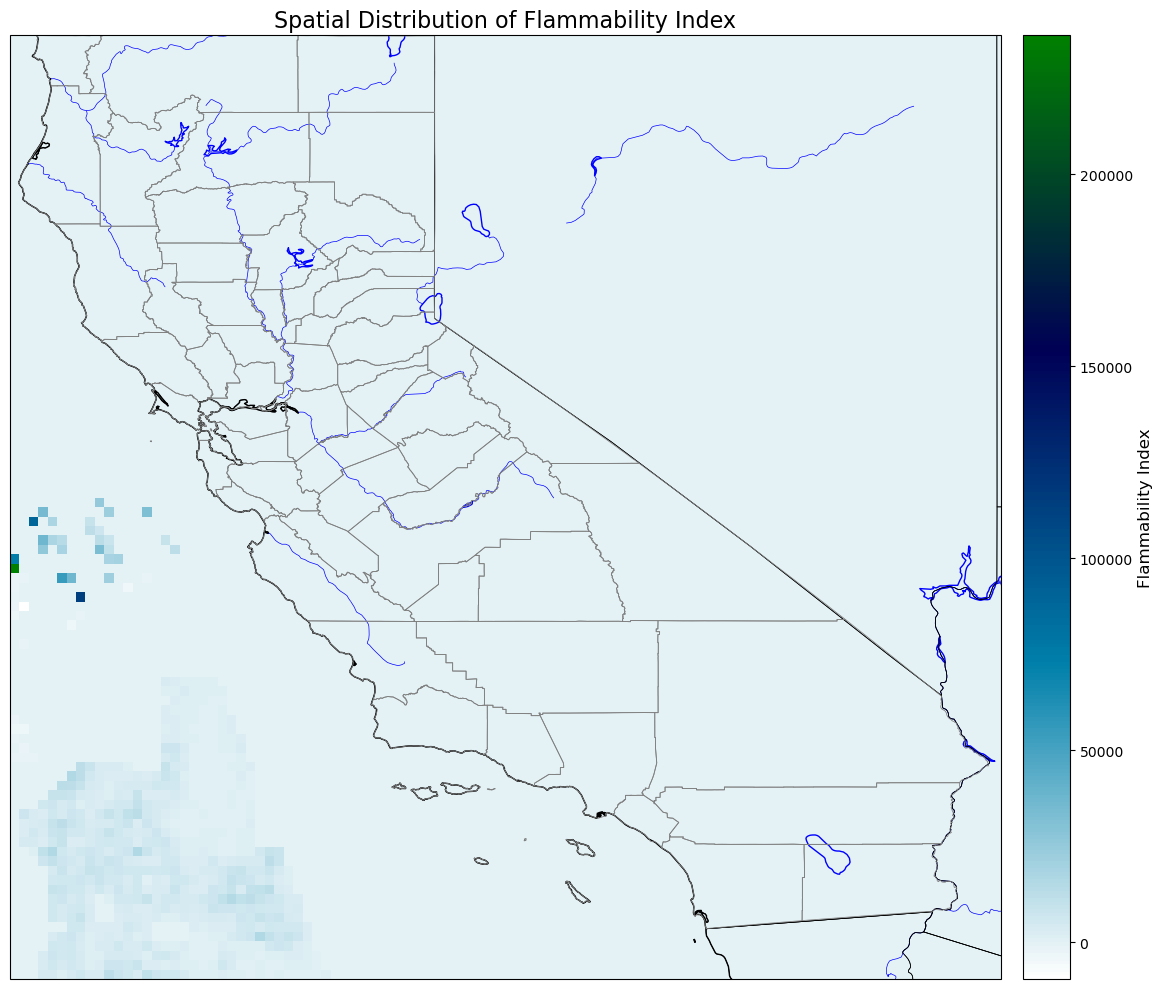

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.ticker import PercentFormatter
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 0. INPUT FILE and OUTPUT FOLDER
flam_tif = r"D:\1Research\2025\NOAA_SatHack\data\sentinel_ca\sentinel_flammability_0p1deg.tif"
out_dir  = r"D:\1Research\2025\NOAA_SatHack\figures\flammability_stats"
os.makedirs(out_dir, exist_ok=True)

# 1. LOAD and MASK
with rasterio.open(flam_tif) as src:
    data = src.read(1)
    nodata = src.nodata
    bounds = src.bounds

# Mask nodata values
if nodata is not None:
    arr = np.ma.masked_equal(data, nodata)
else:
    arr = np.ma.masked_invalid(data)

# Flatten to 1D for stats and plotting
flat = arr.compressed()

# 2. SUMMARY STATISTICS
mn, md, mx = flat.min(), np.median(flat), flat.max()
mean, std    = flat.mean(), flat.std()
print(f"Pixels: {flat.size}")
print(f"Min: {mn:.3f}, Median: {md:.3f}, Mean: {mean:.3f}, Max: {mx:.3f}, Std: {std:.3f}")

# 3. HISTOGRAM
plt.figure(figsize=(8, 5))
n, bins, patches = plt.hist(
    flat, bins=50, color='steelblue', edgecolor='black'
)
plt.xlabel("Flammability Index")
plt.ylabel("Pixel Count")
plt.title("Histogram of Sentinel‐derived Flammability")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "flammability_histogram.png"), dpi=300)
plt.show()

# 4. CUMULATIVE DISTRIBUTION FUNCTION 
plt.figure(figsize=(8, 5))
counts, bin_edges = np.histogram(flat, bins=100)
cdf = np.cumsum(counts) / counts.sum()
plt.plot(bin_edges[1:], cdf, marker='.', linestyle='-',
         color='darkorange')
plt.xlabel("Flammability Index")
plt.ylabel("Cumulative Frequency")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("CDF of Sentinel‐derived Flammability")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "flammability_cdf.png"), dpi=300)
plt.show()

# 5. BOXPLOT
plt.figure(figsize=(4, 6))
plt.boxplot(flat, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen'))
plt.ylabel("Flammability Index")
plt.title("Boxplot of Flammability Values")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "flammability_boxplot.png"), dpi=300)
plt.show()

# 6. SPATIAL MAP
# a) Load CA county shapefile locally
shp_path = r'D:\1Research\2025\NOAA_SatHack\cb_2018_us_county_500k\cb_2018_us_county_500k.shp'
counties = gpd.read_file(shp_path)
ca_counties = counties[counties.STATEFP == '06']

# b) Mask zero‐values so they render white
arr_masked = np.ma.masked_equal(arr, 0.0)

# c) Prepare diverging cmap and norm centered at zero
cmap = plt.get_cmap('ocean_r').copy()
cmap.set_bad('white')

# d) Compute lon/lat edges from the raster bounds and shape
nx = arr_masked.shape[1]
ny = arr_masked.shape[0]
lon_edges = np.linspace(bounds.left,  bounds.right, nx + 1)
lat_edges = np.linspace(bounds.bottom, bounds.top,  ny + 1)

# e) Create figure and Cartopy axis
fig, ax = plt.subplots(
    1, 1, figsize=(12, 10),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)
ax.set_extent(
    [bounds.left, bounds.right, bounds.bottom, bounds.top],
    crs=ccrs.PlateCarree()
)

# f) Add full Natural Earth geography
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.LAKES.with_scale('10m'),
               facecolor='none', edgecolor='blue')
ax.add_feature(cfeature.RIVERS.with_scale('10m'),
               edgecolor='blue', linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('10m'),
               edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('10m'),
               edgecolor='black', linewidth=0.5)

# g) Overlay CA county boundaries
ax.add_geometries(
    ca_counties.geometry,
    crs=ccrs.PlateCarree(),
    edgecolor='gray',
    facecolor='none',
    linewidth=0.6
)

# h) Plot the flammability grid with cwr centered on zero
mesh = ax.pcolormesh(
    lon_edges, lat_edges, arr_masked,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    shading='auto'
)

# i) Add a vertical colorbar
cbar = plt.colorbar(
    mesh, ax=ax,
    orientation='vertical',
    pad=0.02, fraction=0.046
)
cbar.set_label('Flammability Index', fontsize=12)

# j) Title and save
ax.set_title('Spatial Distribution of Flammability Index', fontsize=16)
plt.tight_layout()

out_path = os.path.join(out_dir, 'flammability_map_cwr.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()
